In [2]:
import os
import sys
import json
import random
import subprocess
from pathlib import Path

from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sgfmill import sgf

sys.path.append(str(Path(os.getcwd()).parent))

from src import SGF_PATH, KATAGO_PATH, DATA_PATH
from src.utils.game import Game
from src.utils.sgf_helper import get_moves, opponent

In [28]:
root_path = Path(os.getcwd()).parent
with open(root_path.joinpath("data/analysis_selected_games.json")) as f:
    data = json.load(f)


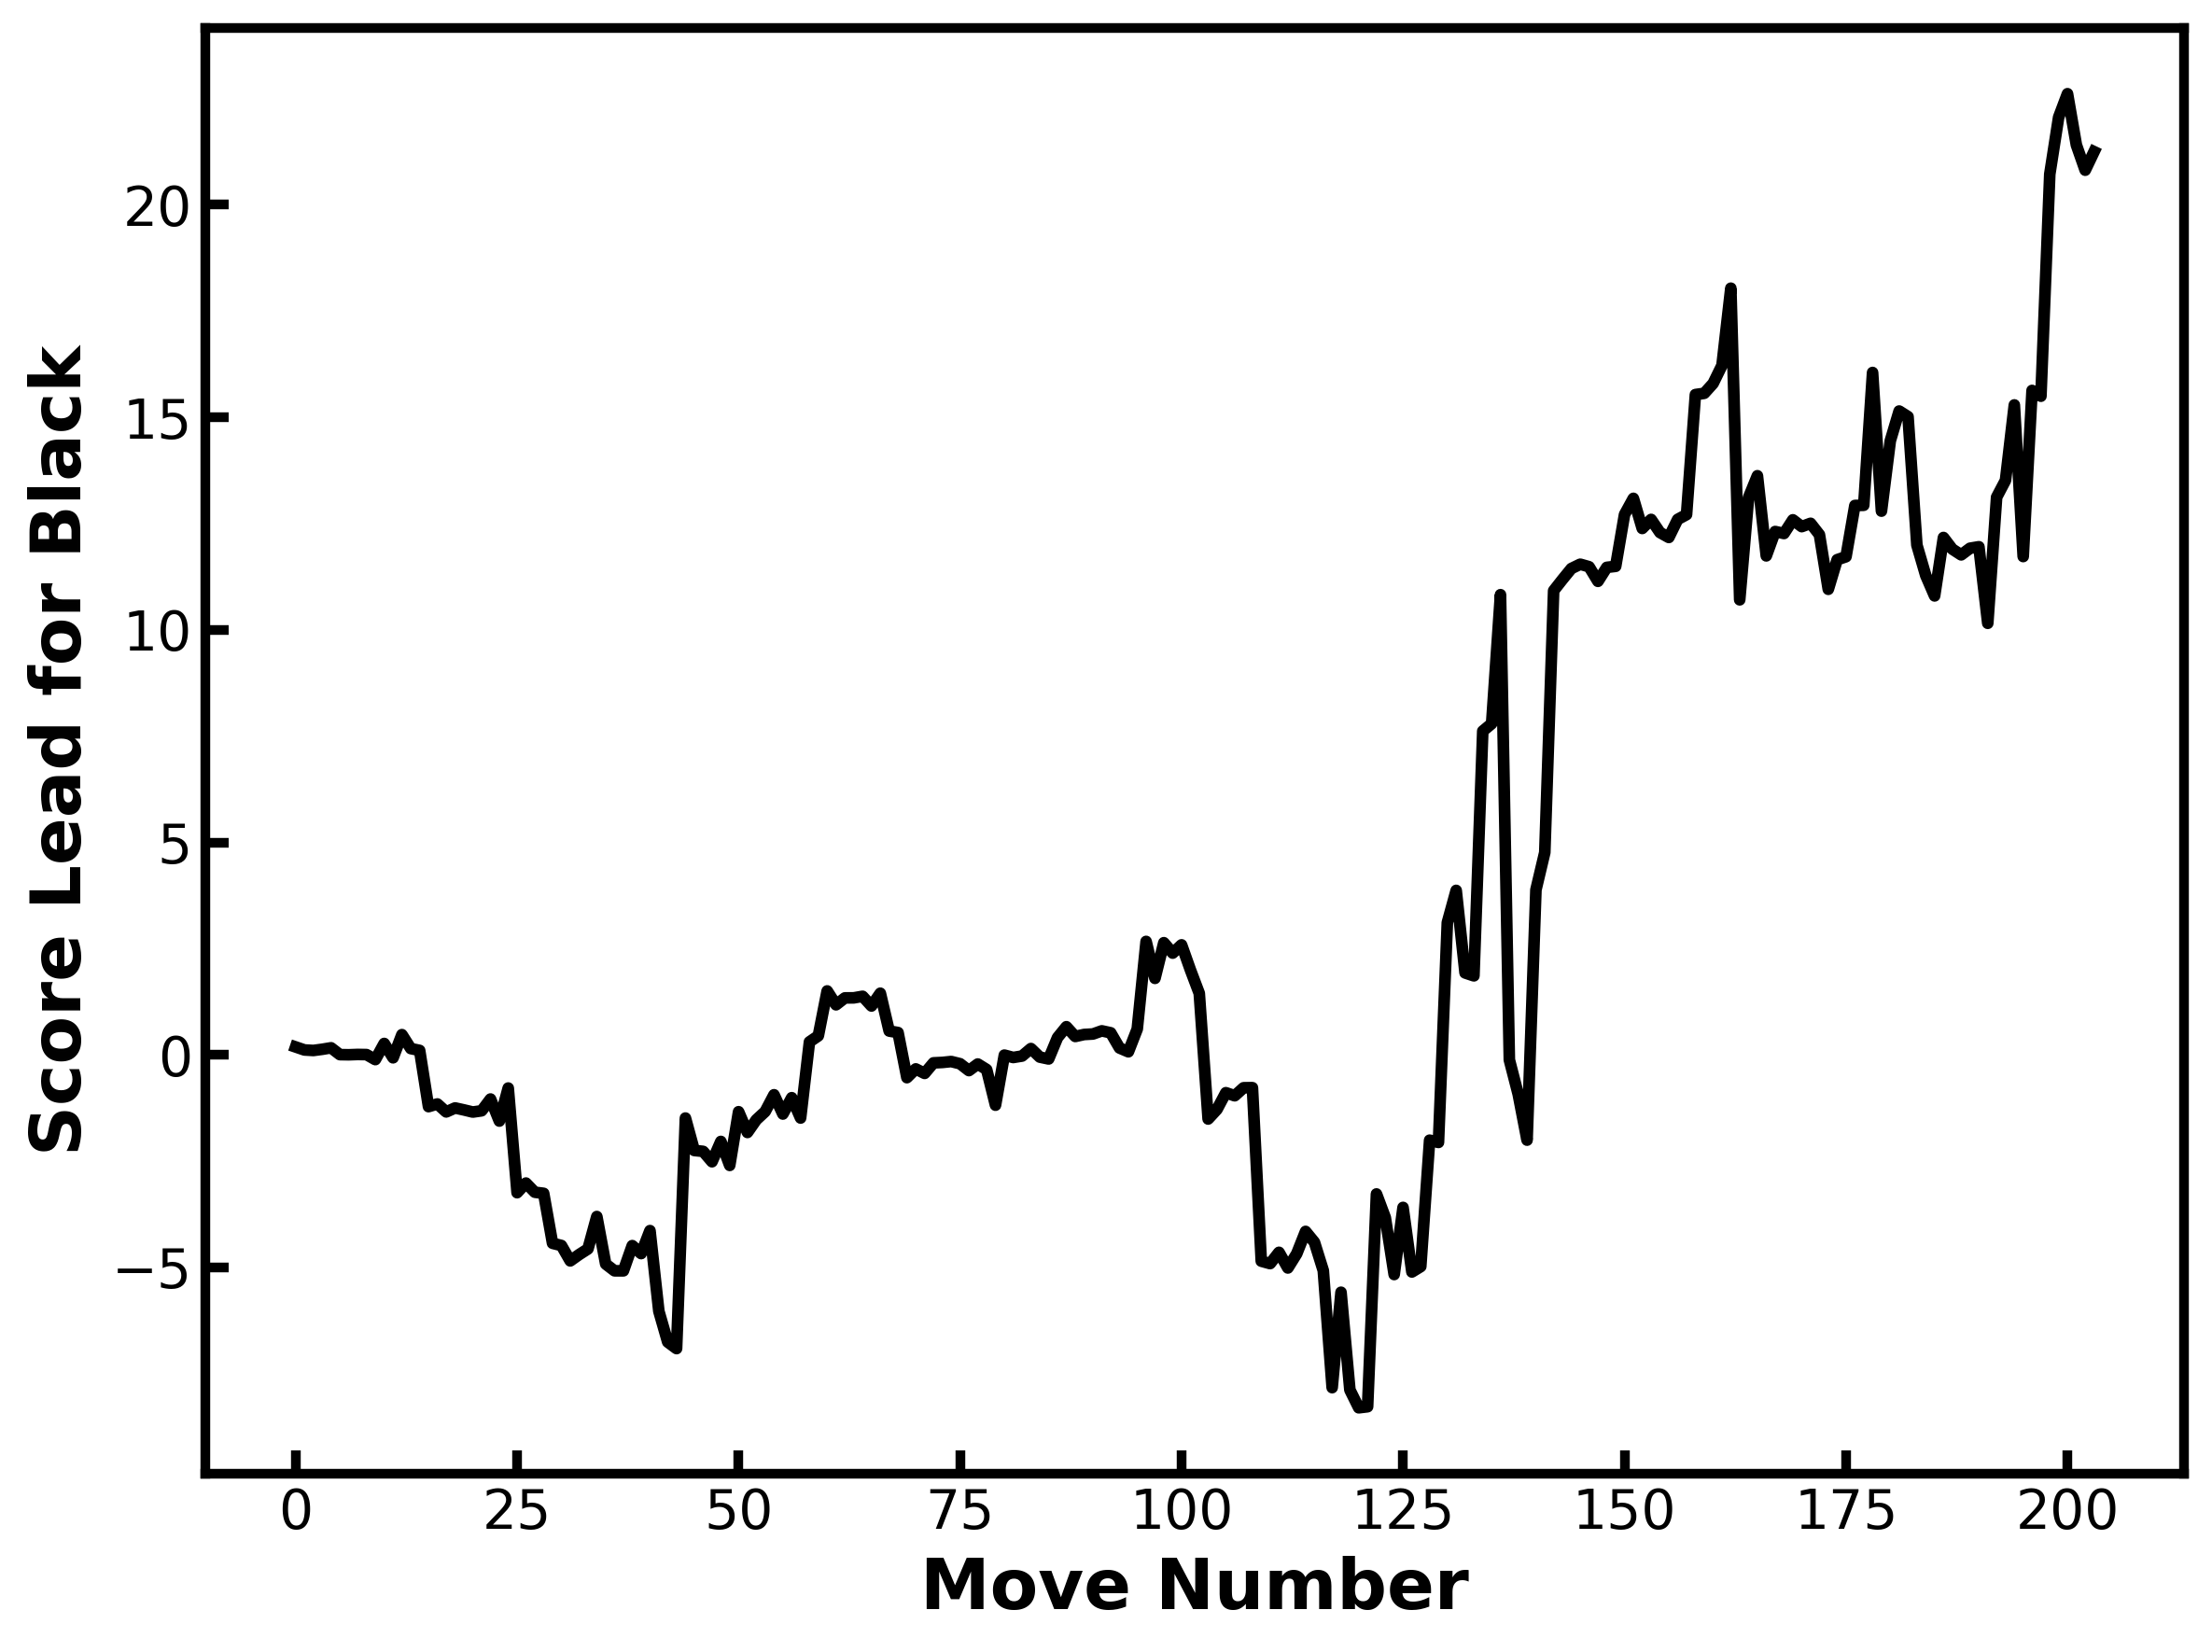

In [30]:
sgfname = "8.sgf"
game = data[sgfname]
game.sort(key=lambda m: m["turnNumber"])
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Plot the data with a clear line width
ax.plot([m["rootInfo"]["scoreLead"] for m in game], linewidth=3, color='black')

# Axis labels with bold formatting
ax.set_xlabel("Move Number", fontsize=18, fontweight='bold')
ax.set_ylabel("Score Lead for Black", fontsize=18, fontweight='bold')

# Customize tick parameters for better visibility
ax.tick_params(axis='both', which='major', labelsize=14, width=2.5, length=6, direction='in')

# Set thicker axis spines
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(2.5)

# Optional: Add grid with subtle styling
# ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Adjust layout to prevent cropping of labels
plt.tight_layout()
plt.savefig("score_lead_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
def get_sgf_sequences(filenames) -> list:
    sgf_games = []
    for filename in filenames:
        with open(SGF_PATH.joinpath(f"{filename}.sgf"), "rb") as f:
            sgf_games.append(f.read())
    return sgf_games


def has_captures(sgf_game, start, amount):
    last_captures = game.captured_black + game.captured_white

    for node in sgf_game[start : start + amount]:
        _, move = node.get_move()
        game.add_move(*move)
        new_amount_captures = game.captured_black + game.captured_white
        if new_amount_captures != last_captures:
            return True
    return False


def possible_variations(
    moves: list[tuple[str, str]], current_player: str, branch: list = []
) -> list:
    if not moves:
        return [branch]

    variations = []
    player_moves = [move for move in moves if move[0] == current_player]

    for pm in player_moves:
        new_moves = [m for m in moves if m != pm]
        new_branch = branch + [pm]
        variations += possible_variations(
            new_moves, opponent(current_player), new_branch
        )

    return variations


def send_position_into_analysis(process, data: dict) -> None:
    # katago analyse requires input as oneline
    data_string = json.dumps(data).replace("\n", "") + "\n"
    process.stdin.write(data_string)
    process.stdin.flush()

In [5]:
model_path = str(KATAGO_PATH.joinpath("models", "b28c512nbt.bin.gz"))
config_path = str(KATAGO_PATH.joinpath("configs", "analysis_example.cfg"))

process = subprocess.Popen(
    ["katago", "analysis", "-config", config_path, "-model", model_path],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1,
)

In [ ]:
sgf_games = get_sgf_sequences([i for i in range(1, 21)])

katago_sequence_results = []

game_id = 1
sgf_game = sgf.Sgf_game.from_bytes(sgf_games[game_id - 1]).get_main_sequence()[1:]

start, amount = 0, 0
while True:
    start, amount = random.randint(0, len(sgf_game) - 10), random.randint(3, 10)

    game = Game()
    for node in sgf_game[:start]:
        _, move = node.get_move()
        if not move:
            continue
        game.add_move(*move)

    if not has_captures(sgf_game, start, amount):
        break

moves = get_moves(SGF_PATH.joinpath(f"{game_id}.sgf"))
selected_moves = moves[start : start + amount]
next_player = selected_moves[0][0]
variations = possible_variations(selected_moves, next_player)
possible_games = [moves[:start] + v for v in variations]

results = {str(i): [] for i in range(len(possible_games))}
analyse_turns = [i for i in range(start, start + amount)]

for i, g in enumerate(possible_games):
    data = {
        "id": str(i),  # has to be string
        "initialStones": [],
        "moves": g,
        "rules": "tromp-taylor",
        "komi": 6.5,
        "boardXSize": 19,
        "boardYSize": 19,
        "analyzeTurns": analyse_turns,
    }
    send_position_into_analysis(process, data)

for i in tqdm(range(amount * len(possible_games))):
    while True:
        new_data = process.stdout.readline().strip()
        if new_data:
            result = json.loads(new_data)
            results[result["id"]].append(result)
            break

diffs = [
    (
        k,
        abs(
            np.array([m["rootInfo"]["scoreLead"] for m in v])
            - np.array(
                [v[max(0, i - 1)]["rootInfo"]["scoreLead"] for i in range(len(v))]
            )
        ).mean(),
    )
    for k, v in results.items()
]
diffs.sort(key=lambda r: r[1])

katago_sequence_results.append(
    {"game_id": game_id, "start": start, "amount": amount, "diffs": diffs}
)
process.terminate()

100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


In [ ]:
with open("katago_results.json", "w") as f:
    json.dump(katago_sequence_results, f, indent=4)

In [ ]:
plt.bar([d[0] for d in diffs], [d[1] for d in diffs])
plt.xlabel("Labels")
plt.ylabel("Height")
plt.title("Mean score error between moves of sequences")

plt.xticks(rotation=90)
plt.figure(figsize=(10, 20))


In [ ]:
plt.plot(
    [
        m["rootInfo"]["scoreLead"]
        for m in katago_sequence_results[0][start : start + amount]
    ],
    label="Game Variation",
)
plt.plot([m["rootInfo"]["scoreLead"] for m in results[str(0)]], label="Other Bariation")
plt.title("Score lead of variations")
plt.legend()
plt.show()

In [17]:
with open(DATA_PATH.joinpath("katago_results.json")) as f:
    results = json.load(f)

In [18]:
runs_per_missing_moves = [
    (i, [result["amount"] for result in results].count(i)) for i in range(3, 9)
]
runs_per_missing_moves

[(3, 74), (4, 67), (5, 70), (6, 68), (7, 66), (8, 55)]

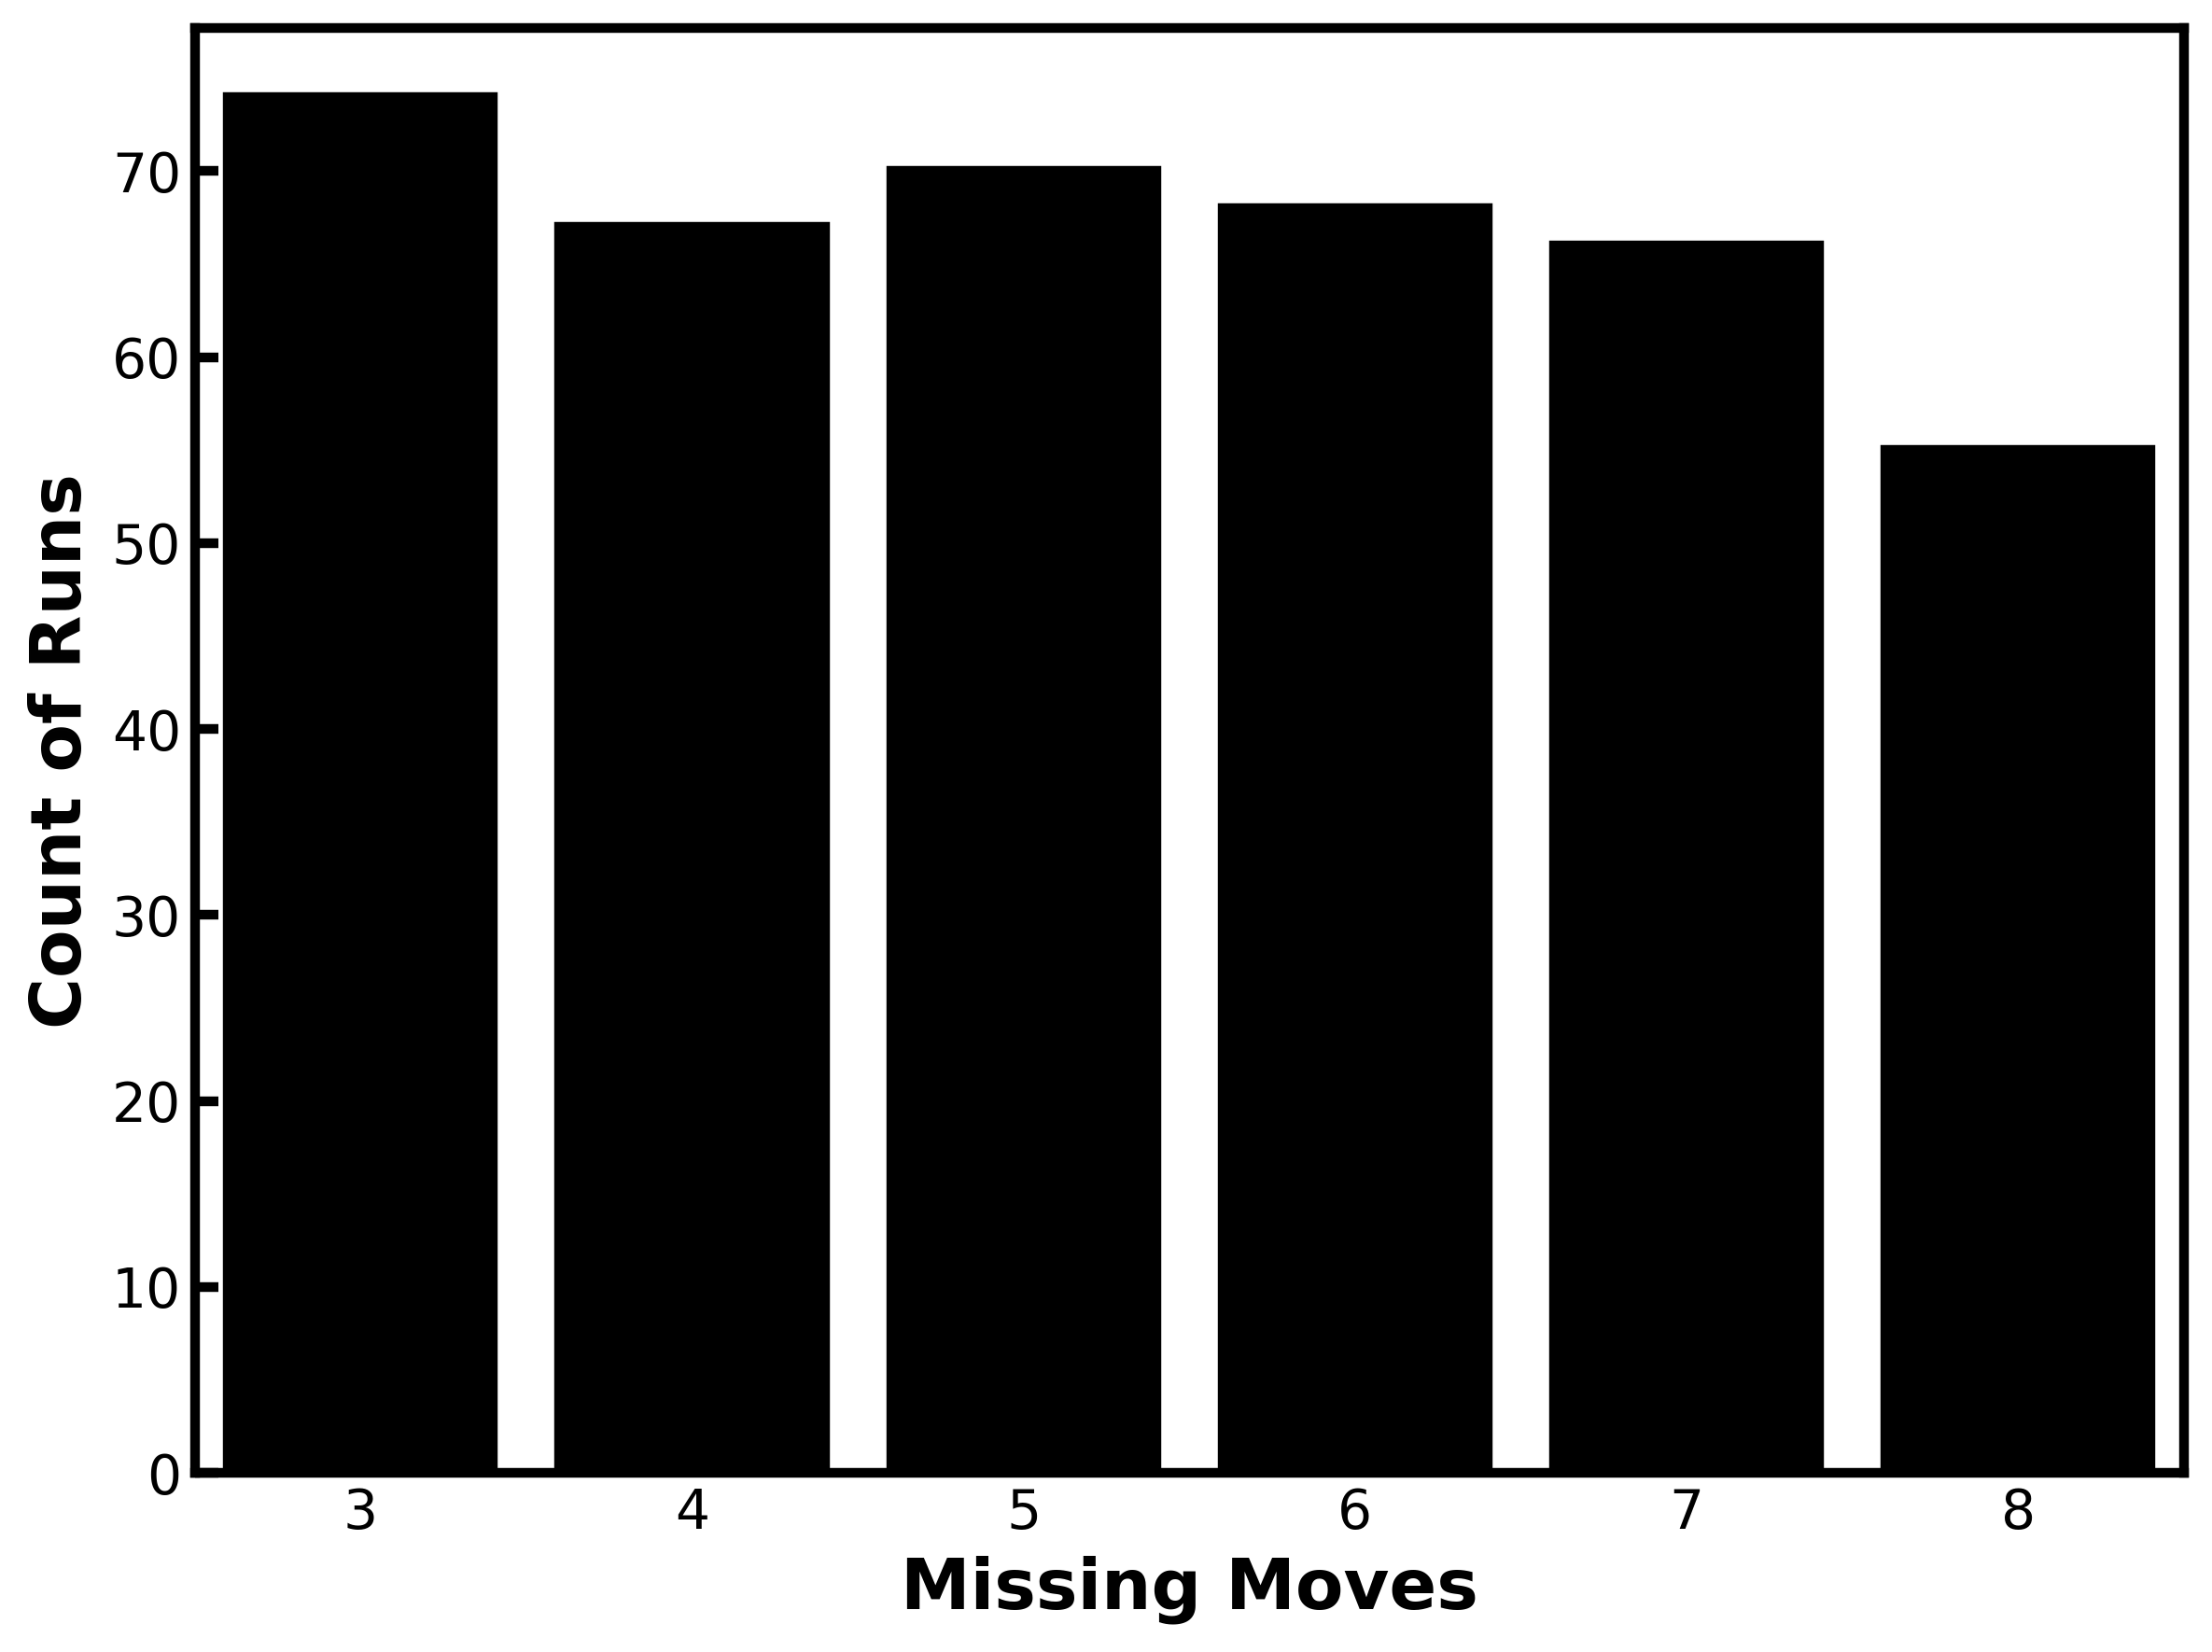

In [20]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Seaborn bar plot with black bars
sns.barplot(
    x=[r[0] for r in runs_per_missing_moves],
    y=[r[1] for r in runs_per_missing_moves],
    errorbar=None,
    color="black",
    edgecolor="black",
    linewidth=2.5
)

# Axis labels with bold formatting
ax.set_xlabel("Missing Moves", fontsize=18, fontweight='bold')
ax.set_ylabel("Count of Runs", fontsize=18, fontweight='bold')

# Customize tick parameters for better visibility
ax.tick_params(axis='both', which='major', labelsize=14, width=2.5, length=6, direction='in')

# Set thicker axis spines
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(2.5)

# Optional: Add grid with subtle styling
# ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Adjust layout to prevent cropping of labels
plt.tight_layout()

# Save as a high-resolution PNG (change to PDF if needed)
plt.savefig("barplot_missing_moves.png", dpi=300, bbox_inches='tight')

plt.show()

In [23]:
for r in results:
    r["position"] = next(i for i, d in enumerate(r["diffs"]) if d[0] == str(0))
    r["position_percent"] = r["position"] / len(r["diffs"])
    r["score_diff_0"] = r["diffs"][0][1] - r["diffs"][r["position"]][1]
    r["score_diff_max"] = r["diffs"][0][1] - r["diffs"][-1][1]

<Axes: xlabel='amount', ylabel='position'>

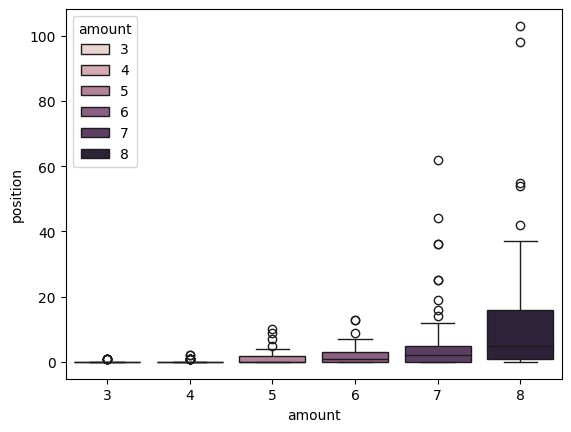

In [25]:
sns.boxplot(pd.DataFrame(results), x="amount", y="position", hue="amount")


In [21]:
sns.boxplot(pd.DataFrame(results), x="amount", y="position_percent", hue="amount")
sns.boxplot(pd.DataFrame(results), x="amount", y="score_diff_max", hue="amount")
sns.boxplot(pd.DataFrame(results), x="amount", y="score_diff_0", hue="amount")


ValueError: Could not interpret value `position_percent` for `y`. An entry with this name does not appear in `data`.

In [26]:
results

[{'game_id': 1,
  'start': 102,
  'amount': 5,
  'diffs': [['2', 0.3194490420000001],
   ['0', 0.3928270380000004],
   ['3', 0.7044496480000003],
   ['6', 1.1063297840000001],
   ['4', 1.1347955400000007],
   ['1', 1.281914508],
   ['10', 1.293590004],
   ['8', 2.163529686],
   ['11', 2.392565252],
   ['5', 2.4845014900000004],
   ['9', 3.0943936059999997],
   ['7', 3.27277283]],
  'position': 1,
  'position_percent': 0.08333333333333333,
  'score_diff_0': -0.07337799600000028,
  'score_diff_max': -2.953323788},
 {'game_id': 1,
  'start': 246,
  'amount': 4,
  'diffs': [['3', 0.2955824000000007],
   ['0', 0.4588633],
   ['1', 2.0815849],
   ['2', 4.901283949999999]],
  'position': 1,
  'position_percent': 0.25,
  'score_diff_0': -0.16328089999999928,
  'score_diff_max': -4.605701549999998},
 {'game_id': 1,
  'start': 12,
  'amount': 7,
  'diffs': [['48', 0.20486242185714287],
   ['10', 0.2359055331857143],
   ['138', 0.2676288984285714],
   ['6', 0.2904046264285714],
   ['27', 0.295946

/var/folders/w7/7cx3tt4j6cx7ymjcjlg47w0c0000gn/T/ipykernel_37721/655795055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="amount", y="position_percent", ax=axes[0], palette=[0] * 3 +[1])
/var/folders/w7/7cx3tt4j6cx7ymjcjlg47w0c0000gn/T/ipykernel_37721/655795055.py:8: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=data, x="amount", y="position_percent", ax=axes[0], palette=[0] * 3 +[1])


ValueError: Invalid RGBA argument: 0

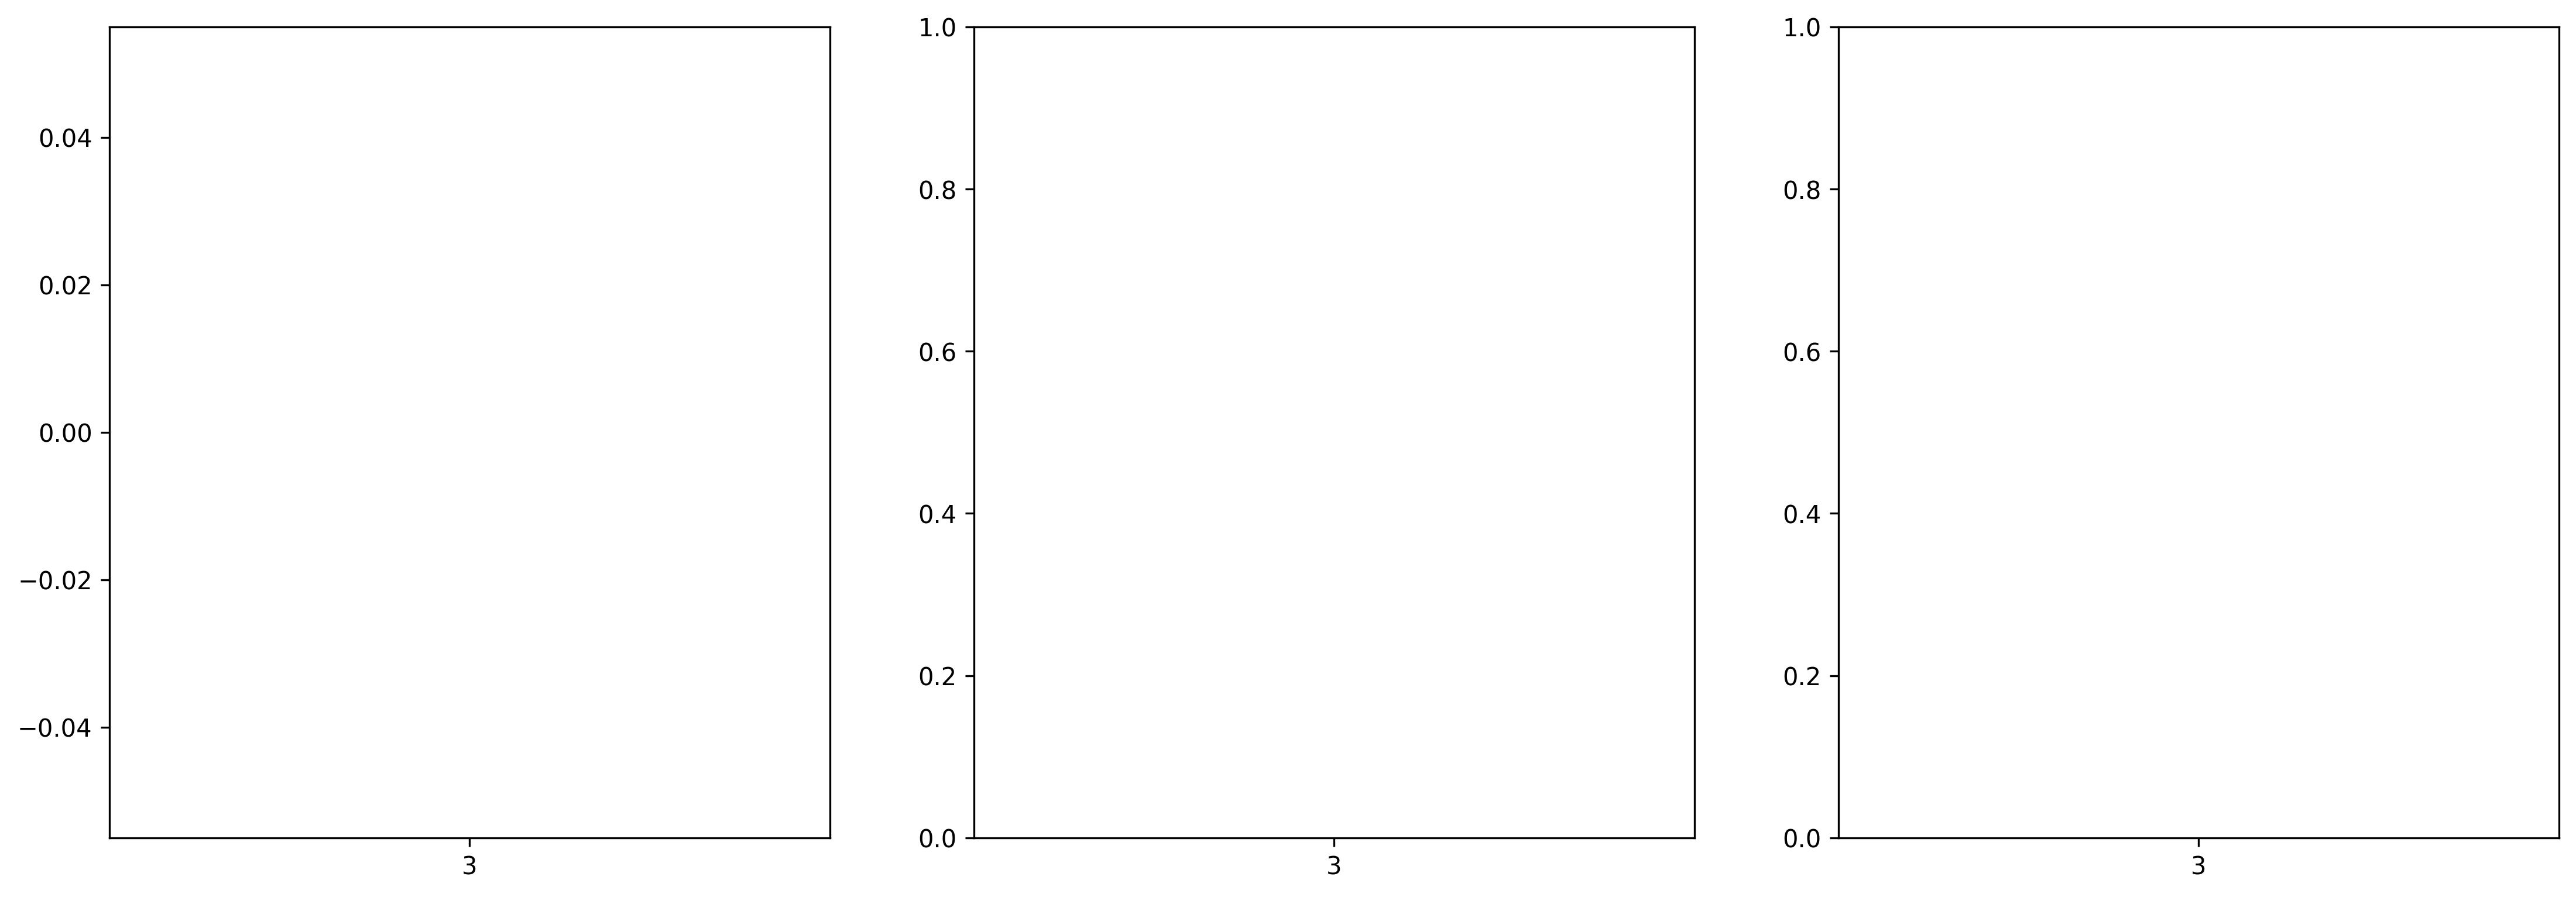

In [ ]:
data = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300, sharex=True)

# Set a single color for all bars
color = "black"

# Boxplot 1: position_percent
sns.boxplot(data=data, x="amount", y="position_percent", ax=axes[0], palette=[color] * 3)
axes[0].set_ylabel("Position Percent", fontsize=18, fontweight='bold')

# Boxplot 2: score_diff_max
sns.boxplot(data=data, x="amount", y="score_diff_max", ax=axes[1], palette=[color] * 3)
axes[1].set_ylabel("Score Diff Max", fontsize=18, fontweight='bold')

# Boxplot 3: score_diff_0
sns.boxplot(data=data, x="amount", y="score_diff_0", ax=axes[2], palette=[color] * 3)
axes[2].set_ylabel("Score Diff 0", fontsize=18, fontweight='bold')

# Formatting all subplots
for ax in axes:
    ax.set_xlabel("Amount", fontsize=18, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14, width=2.5, length=6, direction='in')
    ax.spines["top"].set_linewidth(2.5)
    ax.spines["right"].set_linewidth(2.5)
    ax.spines["bottom"].set_linewidth(2.5)
    ax.spines["left"].set_linewidth(2.5)

# Adjust layout for clarity
plt.tight_layout()

# Save as a high-quality image (PNG or PDF)
plt.savefig("boxplots_single_color.png", dpi=300, bbox_inches='tight')

plt.show()